## Dengue Exercise (Part 2)

In the previous exercise you have fit a static model to predict dengue cases using training data from 2004-2006. This means that you learn a single, unchanging modal which you use to predict future
File display
cases. In this exercise, you will fit a dynamic model that is retrameu ur each prediction step. You will then add more features that will turn your model to a basic ARGO model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
###### from previous exercise ######
df = pd.read_csv('./data/MX_Dengue_trends.csv')
df['Date'] = pd.to_datetime(df['Date'])

display(df.head())

df_train = df.iloc[:36, :]

mod = LinearRegression()
mod.fit(df_train[['dengue']], df_train['Dengue CDC'])
m = mod.coef_[0]
b = mod.intercept_


df_valid = df.iloc[36:, :]
pred_static = df_valid['dengue'] * m + b

,Date,Dengue CDC,dengue,sintomas de dengue,mosquito,dengue sintomas
0,2004-01-01,98,6,0,57,0
1,2004-02-01,41,8,0,51,0
2,2004-03-01,53,3,0,30,14
3,2004-04-01,92,5,0,80,0
4,2004-05-01,100,2,0,21,0


a) In a sliding window approach, the original training period (Jan. 2004 - Dec. 2006) is used to fit a least squares model and predict the next time step (January 2007). Then for the next prediction, the training period shifts by one month (Feb. 2004 - Jan. 2007), and the model is retrained. This process is continued for each prediction from 2007-2011. Implement this approach and store the predictions in a vector.

In [4]:
pred_dyn = np.zeros(df_valid.shape[0])

for month in range(36, df.shape[0]):
    
    # define training set
    start = month - 36
    end = month
    df_train = df.iloc[start:end]
    df_pred = df.iloc[month:month+1]
    
    # fit model
    lr = LinearRegression()
    lr.fit(df_train[['dengue']], df_train['Dengue CDC'])
    
    # make prediction
    pred = lr.predict(df_pred[['dengue']])
    pred_dyn[month - 36] = pred.item() 

b) Plot the number of cases predicted by this method and compare with the predictions from the static model.

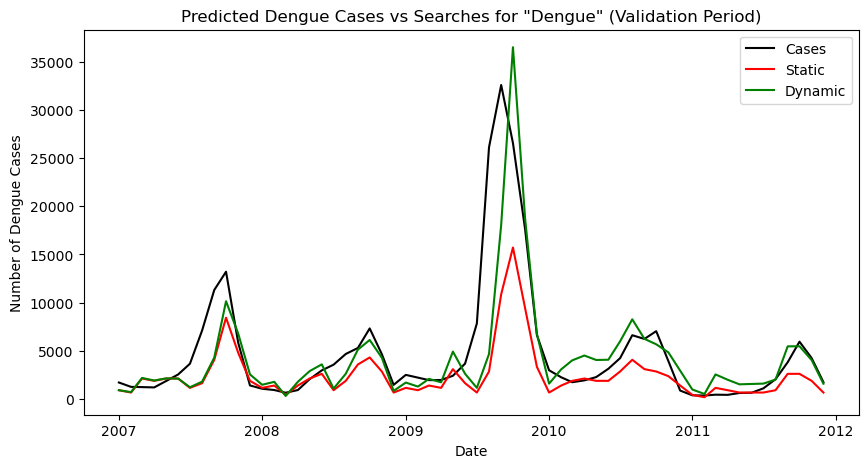

In [6]:
fig_b = plt.figure(figsize=(10, 5))
plt.plot(df_valid['Date'], df_valid['Dengue CDC'], c='k', label='Cases')
plt.plot(df_valid['Date'], pred_static, c='r', label='Static')
plt.plot(df_valid['Date'], pred_dyn, c='g', label='Dynamic')
plt.xlabel('Date')
plt.ylabel('Number of Dengue Cases')
plt.title('Predicted Dengue Cases vs Searches for "Dengue" (Validation Period)')
plt.legend()
plt.show()

c) Compute the mean square error (MSE) of both methods compared with the ground truth.
Which method is better?

In [7]:
def rmse(truth, pred):
    return np.sqrt(np.mean((truth - pred) ** 2))

print('Static ', rmse(df_valid['Dengue CDC'], pred_static))
print('Dynamic ', rmse(df_valid['Dengue CDC'], pred_dyn))


Static  4968.412293227814
Dynamic  4039.9589434991985


d) Adding covariates. Instead of using just "dengue" as the predictor variable, add the remaining Google search terms as predictors in the dynamic model. How does the MSE change?

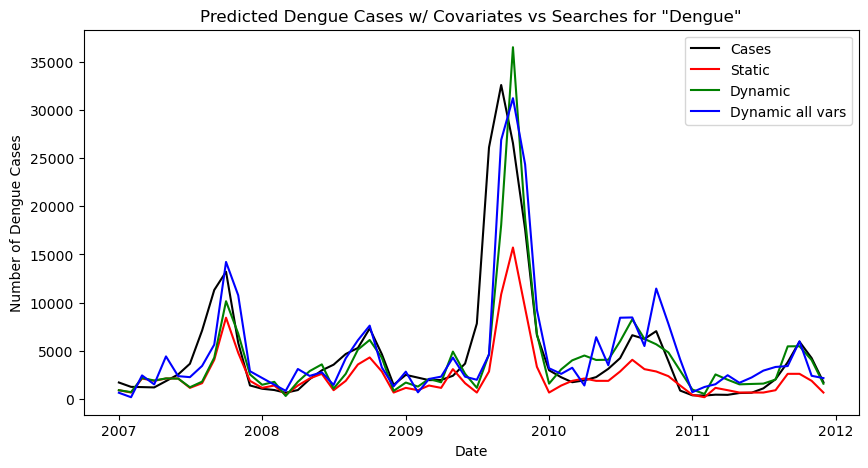

Static  4968.412293227814
Dynamic  4039.9589434991985
Dynamic all vars 3683.5935619672086


In [12]:
pred_dyn_all = np.zeros(df_valid.shape[0])
features = ['dengue', 'sintomas de dengue', 'mosquito', 'dengue sintomas']

for month in range(36, df.shape[0]):
    
    # define training set
    start = month - 36
    end = month
    df_train = df.iloc[start:end]
    df_pred = df.iloc[month:month+1]
    
    # fit model
    lr = LinearRegression()
    lr.fit(df_train[features], df_train['Dengue CDC'])
    
    # make prediction
    pred = lr.predict(df_pred[features])
    pred_dyn_all[month - 36] = pred.item()

fig_d = plt.figure(figsize=(10, 5))
plt.plot(df_valid['Date'], df_valid['Dengue CDC'], c='k', label='Cases')
plt.plot(df_valid['Date'], pred_static, c='r', label='Static')
plt.plot(df_valid['Date'], pred_dyn, c='g', label='Dynamic')
plt.plot(df_valid['Date'], pred_dyn_all, c='b', label='Dynamic all vars')
plt.xlabel('Date')
plt.ylabel('Number of Dengue Cases')
plt.title('Predicted Dengue Cases w/ Covariates vs Searches for "Dengue"')
plt.legend()
plt.show()


print('Static ', rmse(df_valid['Dengue CDC'], pred_static))
print('Dynamic ', rmse(df_valid['Dengue CDC'], pred_dyn))
print('Dynamic all vars', rmse(df_valid['Dengue CDC'], pred_dyn_all))

e) Adding autoregression. You can make use of the fact that the model changes over time to improve predictions by adding past observations of the ground truth as additional features. For example, for the Jan. 2007 prediction, you can add the observed dengue case counts from Nov. 2006 and Dec. 2006 as features (this is a Google+AR2 model). Implement a dynamic model with autoregression and compare the MSE of this model with the others.

Hint: Shift the case count column and stack it to the original data matrix. Your sliding training window for the first two predictions can have fewer than 36 observations.

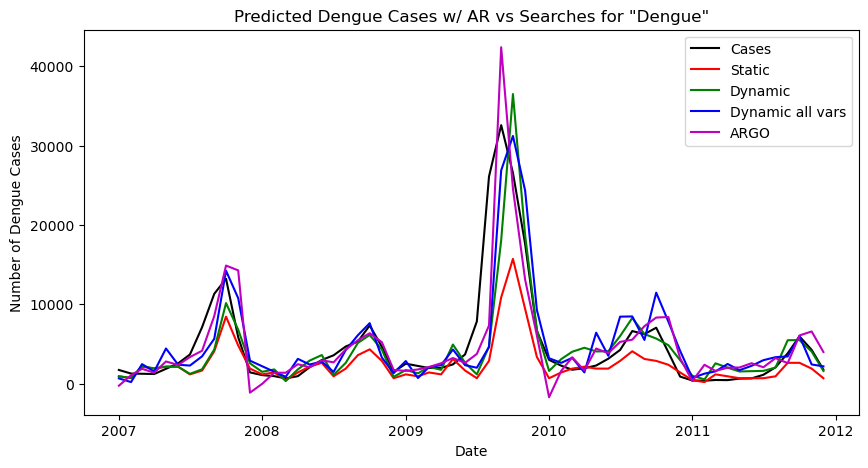

Static  4968.412293227814
Dynamic  4039.9589434991985
Dynamic all vars 3683.5935619672086
ARGO 3391.197325221173


In [13]:
# add AR terms
df['ar1'] = df['Dengue CDC'].shift(1)
df['ar2'] = df['Dengue CDC'].shift(2)

pred_dyn_ar = np.zeros(df_valid.shape[0])
features = ['dengue', 'sintomas de dengue',
            'mosquito', 'dengue sintomas', 'ar1', 'ar2']

for month in range(36, df.shape[0]):
    
    # define training set
    start = max(month - 36, 2)      # notice difference here
    end = month
    df_train = df.iloc[start:end]
    df_pred = df.iloc[month:month+1]
    
    # fit model
    lr = LinearRegression()
    lr.fit(df_train[features], df_train['Dengue CDC'])
    
    # make prediction
    pred = lr.predict(df_pred[features])
    pred_dyn_ar[month - 36] = pred.item()

fig_e = plt.figure(figsize=(10, 5))
plt.plot(df_valid['Date'], df_valid['Dengue CDC'], c='k', label='Cases')
plt.plot(df_valid['Date'], pred_static, c='r', label='Static')
plt.plot(df_valid['Date'], pred_dyn, c='g', label='Dynamic')
plt.plot(df_valid['Date'], pred_dyn_all, c='b', label='Dynamic all vars')
plt.plot(df_valid['Date'], pred_dyn_ar, c='m', label='ARGO')
plt.xlabel('Date')
plt.ylabel('Number of Dengue Cases')
plt.title('Predicted Dengue Cases w/ AR vs Searches for "Dengue"')
plt.legend()
plt.show()


print('Static ', rmse(df_valid['Dengue CDC'], pred_static))
print('Dynamic ', rmse(df_valid['Dengue CDC'], pred_dyn))
print('Dynamic all vars', rmse(df_valid['Dengue CDC'], pred_dyn_all))
print('ARGO', rmse(df_valid['Dengue CDC'], pred_dyn_ar))